In [1]:
import numpy as np
import pandas as pd
import random as rand
import seaborn as sns
import time
from matplotlib import pyplot as plt

%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)
pylab.rcParams['figure.figsize'] = (20, 12)
plt.style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


C:\Users\jdetu\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['rand']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Define functions to prep data.

In [25]:
def train_test_valid(df, train_ratio = 0.6, valid_ratio = 0.2 ):
    
    train, test, validation = np.split(df.sample(frac = 1, 
                                                 random_state = random.randint(1,1e3)), 
                                       [int(train_ratio * len(df)), 
                                        int((train_ratio + valid_ratio) * len(df))])
    
    return train, test, validation

def normalize(df, mean_method = True ):
    if mean_method:
        # mean normalization
        normalized_df = (df - df.mean()) / df.std()
        a, b = df.std(), df.mean()
    else:
        # min max normalization
        normalized_df = (df - df.min()) / (df.max() - df.min())
        a, b = df.min(), df.max()
    return normalized_df, a, b

def unnormalize(df, a, b, mean_method = True):
    if mean_method:
        # mean normalization
        unnormalized_df = df * a + b
    else:
        # min max normalization
        unnormalized_df = (df * (b - a)) + a
    return unnormalized_df

# Decision Tree

In [3]:
class Decision_Tree:
    
    def __init__(self, x, y, 
                 num_features, 
                 min_leaf, 
                 max_depth):
        
        # init data
        self.x = x
        self.y = y
        self.num_rows = x.shape[0]
        
        # init hyperparameters
        self.min_leaf = min_leaf
        self.max_depth = max_depth
        
        # data charactersitics
        self.num_features = num_features 
        self.val = np.mean(y.values[:])
        
        self.score = np.inf
        self.find_split()

        
    def std(self, count, ssum, squared_sum):
        return np.abs( (squared_sum / count) - (ssum / count)**2 )
    
    def find_split(self):
        
        for feature in self.num_features:
            self.check_split(feature)
        
        
        if self.score == np.inf or self.max_depth <= 0:
            return

        x = self.x.values[:, self.split_feature]

        left = np.nonzero(x <= self.split_val)[0]
        right = np.nonzero(x > self.split_val)[0]

        self.left_tree = Decision_Tree(self.x.iloc[left], self.y.iloc[left], self.num_features, self.min_leaf, self.max_depth - 1)
        self.right_tree = Decision_Tree(self.x.iloc[right], self.y.iloc[right], self.num_features, self.min_leaf, self.max_depth - 1)

    def check_split(self, feature):
        
        # sort data
        x = self.x.values[:, feature][np.argsort(self.x.values[:, feature])]
        y = self.y.values[:][np.argsort(self.x.values[:, feature])]
        
        # set counters
        left_count = 0
        left_sum = 0.0
        left_squared_sum = 0.0
        right_count = self.num_rows
        right_sum = np.sum(y)
        right_squared_sum = np.sum(y ** 2)
        
        # loop through data
        for i in range(0, self.num_rows - self.min_leaf):
            
            left_count += 1
            left_sum += y[i]
            left_squared_sum += y[i] ** 2
            
            right_count -= 1            
            right_sum -= y[i]
            right_squared_sum -= y[i] ** 2
            
            # use variance or std as impurity metric
            left_std = self.std(left_count, left_sum, left_squared_sum)
            right_std = self.std(right_count, right_sum, right_squared_sum)
            score = left_std * left_count + right_std * right_count

            if score < self.score:
                self.split_feature = feature
                self.score = score
                self.split_val = x[i]

    def predict_one(self, x):
        
        if self.score == np.inf or self.max_depth <= 0:
            return self.val

        if x[self.split_feature] <= self.split_val:
            return self.left_tree.predict_one(x)
        else:
            return self.right_tree.predict_one(x)
        
    def predict(self, x):
        
        vals = []
        for i in x.values:
            vals.append(self.predict_one(i))
        
        return np.array(vals)

    


# Random Forest 

In [42]:
class Random_Forest:
    
    def __init__(self, x_train, y_train, x_test, y_test, 
                 num_features = None, 
                 num_exemplars = None, 
                 n_estimators = 10,
                 min_leaf=1, 
                 max_depth=10):
        
        # init data
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test 
        
        # init hyperparameters
        self.n_estimators = int(n_estimators)
        self.max_depth = int(max_depth)
        self.min_leaf = int(min_leaf)
        
        if num_features == None:
            num_features = int(x_train.shape[1])
        if num_exemplars == None:
            num_exemplars = x_train.shape[0]
        
        self.num_features = np.random.randint(0, num_features, num_features)
        self.num_exemplars = num_exemplars
        
    def MSE(self, y_pred, y_train):
        return np.sum((y_pred - y_train) ** 2) / (2 * y_train.shape[0])
    
    def MAE(self, y_pred, y_test):
        return (np.mean(np.abs(y_pred-y_test)))

    def fit(self, x, y):
        
        self.trees = [] # create tree for every estimator
        for n in range(self.n_estimators):
            rand_index = np.random.randint(y.shape[0], size = self.num_exemplars)
            self.trees.append(Decision_Tree(x.iloc[rand_index],
                                            y.iloc[rand_index],
                                            self.num_features, 
                                            self.min_leaf, 
                                            self.max_depth))
        
        
    def predict(self, x_test):
        
        y_trees = []
        
        # use every tree to make predictions
        for tree in self.trees:
            y_trees.append(tree.predict(x_test))
            
        # average every decision tree prediction for final y_pred
        y_pred = np.mean(y_trees, axis = 0)
        
        # calc mean square error
        MSE = self.MSE(y_pred, self.y_test)
        
        return y_pred, MSE


# Test Model on Toy Problem

Text(0.5, 1.0, 'Toy Data')

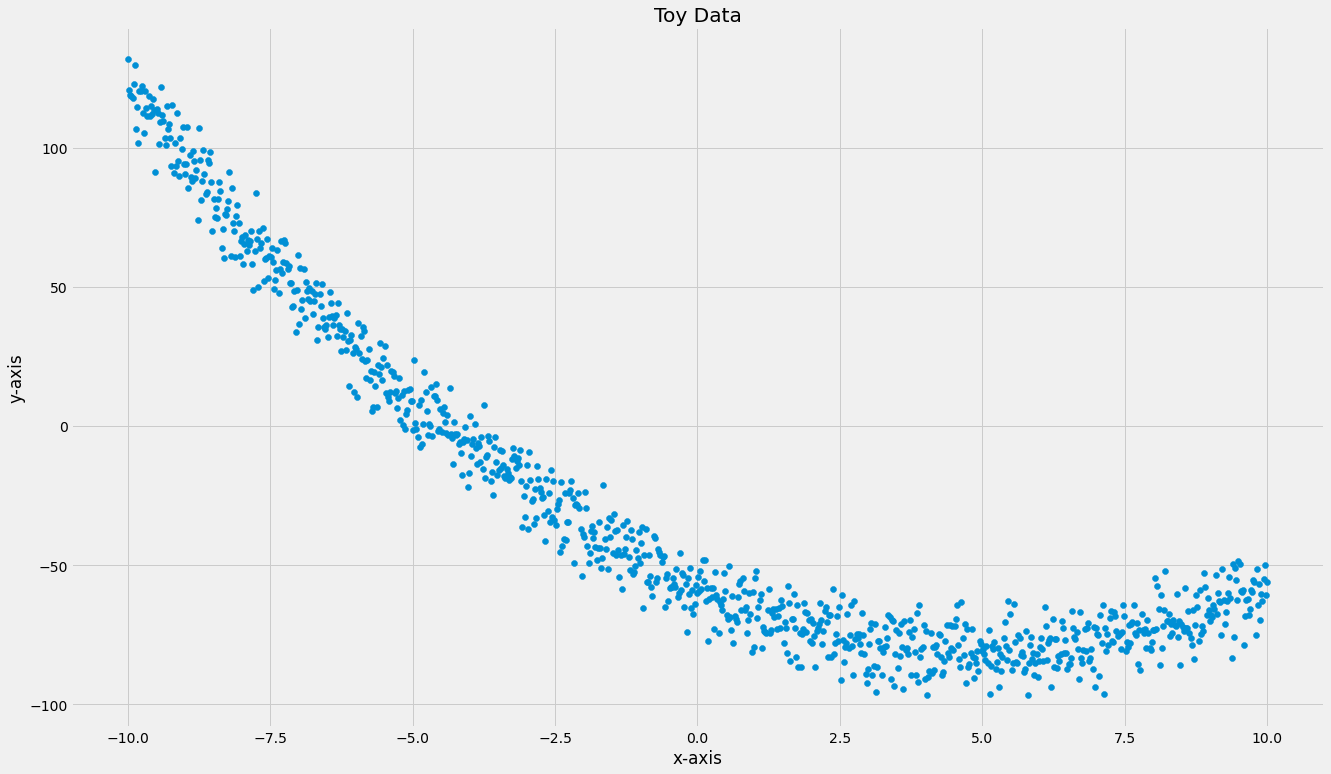

In [5]:
# create synthetic data from polynomial with random coeffs and noise

import random as rand
def f_toy(normal = False, linear = False):
    
    if normal:
        x = []
        for i in range(1000): 
            x.append(random.normal(10, 5))
    else:
        x = np.linspace(-10,10, 1000)
    
    y = []
    
    a = rand.uniform(-1,1)
    b = rand.uniform(-10,10)
    c = rand.uniform(-100,100)
    exp =  2 #rand.randint(0,3)
    
    for i in range(len(x)):
        
        noise = random.uniform(rand.randint(-20,0),rand.randint(0,20))
        
        if linear:
            y.append(a*x[i] + b + noise)
        else:
            y.append(a*x[i]**exp + b*x[i] + c + noise)
            
    return x, y
    
x, y = f_toy(normal = False, linear = False)
plt.scatter(x,y)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Toy Data')

In [51]:
# create datafame from toy data
df_toy = pd.DataFrame(list(x), columns=['x'])
df_toy['y'] = y

# randomly split with 60 / 20 / 20 ratio
train, test, validation = train_test_valid(df_toy)

# normalize data
#train, test, valid = normalize(train), normalize(test), normalize(validation)

# seperate input data from target variable
x_train, y_train = train.iloc[:,:-1], train.iloc[:,-1]
x_test, y_test = test.iloc[:,:-1], test.iloc[:,-1]
x_valid, y_valid = validation.iloc[:,:-1], validation.iloc[:,-1]


In [7]:
RF = Random_Forest(x_train, y_train, x_test, y_test, 
                  n_estimators = 20, 
                  min_leaf = 1, 
                  max_depth = 10)

RF.fit(x_train, y_train)

y_pred, MSE = RF.predict(x_test)
print("Mean Squared Error: {}".format(MSE))

df_pred = pd.DataFrame(np.array(x_test), columns = ['x_test'])
df_pred['y_test'] = np.array(y_test)
df_pred['y_pred'] = y_pred

C:\Users\jdetu\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jdetu\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Squared Error: 33.4417396147597


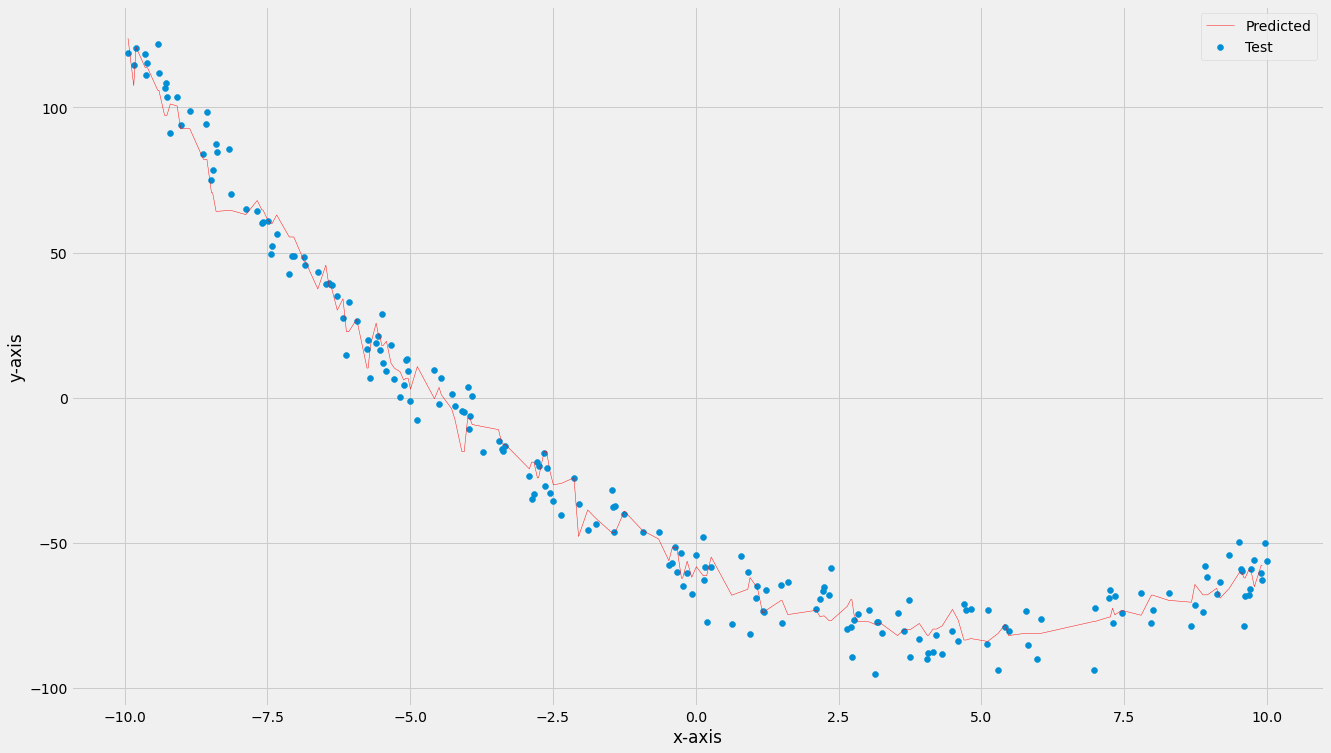

In [8]:
df_pred.sort_values(by = ['x_test'], inplace = True)

plt.scatter(x_test,y_test, 
            label = 'Test')
plt.plot(df_pred['x_test'],df_pred['y_pred'], 
         c = 'red', 
         linewidth = 0.5,
            alpha = 0.9,
         label = 'Predicted')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend()

# Import and process data

In [321]:
df = pd.read_csv('maize_major_yield/maize_major_yield.csv')
df = df.drop(['year'], axis = 1)

# randomly split with 60 / 20 / 20 ratio
train, test, validation = train_test_valid(df)

# normalize data
train, test, valid = normalize(train), normalize(test), normalize(validation)

# seperate input data from target variable
x_train, y_train = train[0].iloc[:,:-1], train[0].iloc[:,-1]
x_test, y_test = test[0].iloc[:,:-1], test[0].iloc[:,-1]
x_valid, y_valid = valid[0].iloc[:,:-1], valid[0].iloc[:,-1]



# Run Random forest to predict crop yield

In [322]:
RF = Random_Forest(x_train, y_train, x_test, y_test,
                  n_estimators = 5,
                  min_leaf = 1, 
                  max_depth = 10)

RF.fit(x_train, y_train) # fit random forest model to training data

# use model to make predictions from test data
y_pred, MSE = RF.predict(x_test) 
print("Mean Squared Error: {}".format(MSE))

C:\Users\jdetu\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jdetu\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Squared Error: 0.21017154512543804


In [323]:
# unnormalize
y_test = unnormalize(y_test, test[1][-1],  test[2][-1])
y_pred = unnormalize(y_pred, test[1][-1],  test[2][-1])

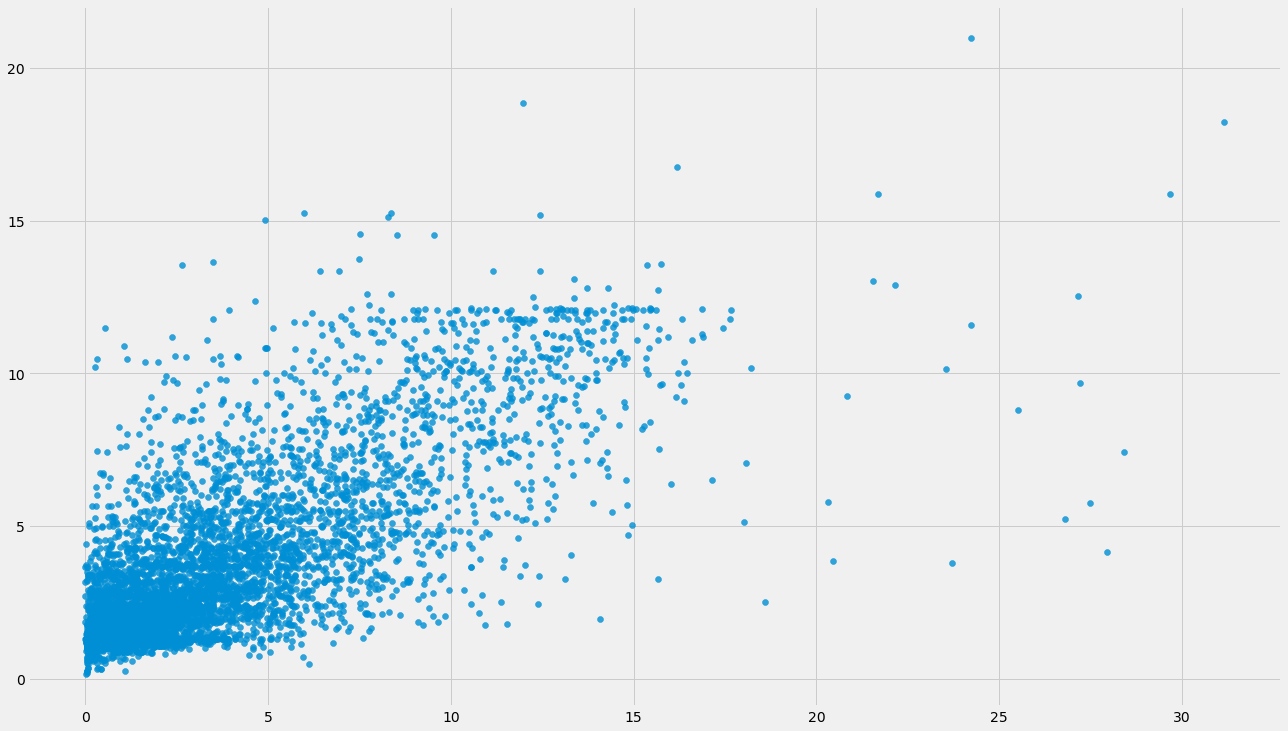

In [324]:
df_pred = pd.DataFrame(list(y_test), columns = ['y_test'])
df_pred['y_pred'] = list(y_pred)

plt.scatter(df_pred['y_test'], df_pred['y_pred'], alpha = 0.8)

In [318]:
df_pred.corr()

,y_test,y_pred
y_test,1.000000,0.702604
y_pred,0.702604,1.000000


In [319]:
RF.MSE(df_pred['y_test'], df_pred['y_pred'])

3.397399586131635

In [320]:
RF.MAE(df_pred['y_test'], df_pred['y_pred'])

1.8356698164139627

# Hyperparameter optimization with test dataset

In [13]:

estimators_space = np.linspace(1,30,30)
depth_space = np.linspace(10,30,5)

previous_MSE = np.inf

results = []
best_results = {}

iteration = 0
for estimators in estimators_space:
    for depth in depth_space:
    
        iteration += 1

        # start timer
        start = time.time()

        RF = Random_Forest(x_train, y_train, x_test, y_test,
                  n_estimators = estimators,
                  min_leaf = 1, 
                  max_depth = depth)

        RF.fit(x_train, y_train) # fit random forest model to training data

        # use model to make predictions from test data
        y_pred, MSE = RF.predict(x_test) 

        # end timer
        end = time.time()
        time_diff =  end - start


        params =[estimators, depth]

        iter_results = {'params':params,
                        'MSE':MSE,
                        'runtime':time_diff}

        results.append(iter_results)

        print(iteration - 1, estimators, depth, MSE)
        #print("Current Step:", step, ' MSE: ', MSE)
        if MSE < previous_MSE:
            best_results.update({'iteration': iteration - 1})
            best_results.update({'params': params})
            best_results.update({'MSE': MSE})
            best_results.update({'runtime': time_diff})

            previous_MSE = MSE

C:\Users\jdetu\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jdetu\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 1.0 10.0 3.737119212709844
1 1.0 15.0 3.883366813606494
2 1.0 20.0 3.8783066475002554
3 1.0 25.0 4.061790705545966
4 1.0 30.0 4.194266915548557
5 2.0 10.0 3.1558074240334757
6 2.0 15.0 2.799152703167891
7 2.0 20.0 2.4931753870452806
8 2.0 25.0 2.3328940234941458
9 2.0 30.0 2.1899550689194767
10 3.0 10.0 2.7202375234533283
11 3.0 15.0 2.227764899617277
12 3.0 20.0 2.0027309091501713
13 3.0 25.0 1.7618428443555132
14 3.0 30.0 1.8355655293082602
15 4.0 10.0 2.769031798098798
16 4.0 15.0 1.869309700897089
17 4.0 20.0 1.6188217443712944
18 4.0 25.0 1.3547481416067422
19 4.0 30.0 1.4100001243252576
20 5.0 10.0 2.609773980062468
21 5.0 15.0 1.797075345596992
22 5.0 20.0 1.2815675394755204
23 5.0 25.0 1.0829062750449
24 5.0 30.0 1.1185226567883808
25 6.0 10.0 2.434453651356486
26 6.0 15.0 1.5891813003708395
27 6.0 20.0 0.9708495372239702
28 6.0 25.0 0.8926339719070795
29 6.0 30.0 0.728862454181486
30 7.0 10.0 2.443376357293295
31 7.0 15.0 1.549579610619889
32 7.0 20.0 0.9285413770073944
33 7

## Save optimal hyperparameters

In [162]:
#mse_vals = [i['MSE'] for i in results[:90]]
#i = mse_vals.index(min(mse_vals))

In [171]:
i = best_results['iteration']
print(results[i])                                               

{'params': [29.0, 25.0], 'MSE': 0.035071550483809805, 'runtime': 40685.66858148575}


In [164]:
best_est = results[i]['params'][0]
best_depth = results[i]['params'][1]

## Run Random forest model with validation data using optimal hyperparameters

In [196]:
df = pd.read_csv('maize_major_yield/maize_major_yield.csv')
df = df.drop(['year'], axis = 1)

# randomly split with 60 / 20 / 20 ratio
train, test, validation = train_test_valid(df)

# normalize data
train, test, valid = normalize(train), normalize(test), normalize(validation)

# seperate input data from target variable
x_train, y_train = train[0].iloc[:,:-1], train[0].iloc[:,-1]
x_test, y_test = test[0].iloc[:,:-1], test[0].iloc[:,-1]
x_valid, y_valid = valid[0].iloc[:,:-1], valid[0].iloc[:,-1]



In [197]:
RF = Random_Forest(x_train, y_train, x_valid, y_valid,
                  n_estimators = best_est,
                  min_leaf = 1, 
                  max_depth =  best_depth)

RF.fit(x_train, y_train) # fit random forest model to training data

# use model to make predictions from validation data
y_pred, MSE = RF.predict(x_valid)

C:\Users\jdetu\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jdetu\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [200]:
# unnormalize
y_pred = unnormalize(y_pred, valid[1][-1],  valid[2][-1])
y_valid = unnormalize(y_valid, valid[1][-1],  valid[2][-1])

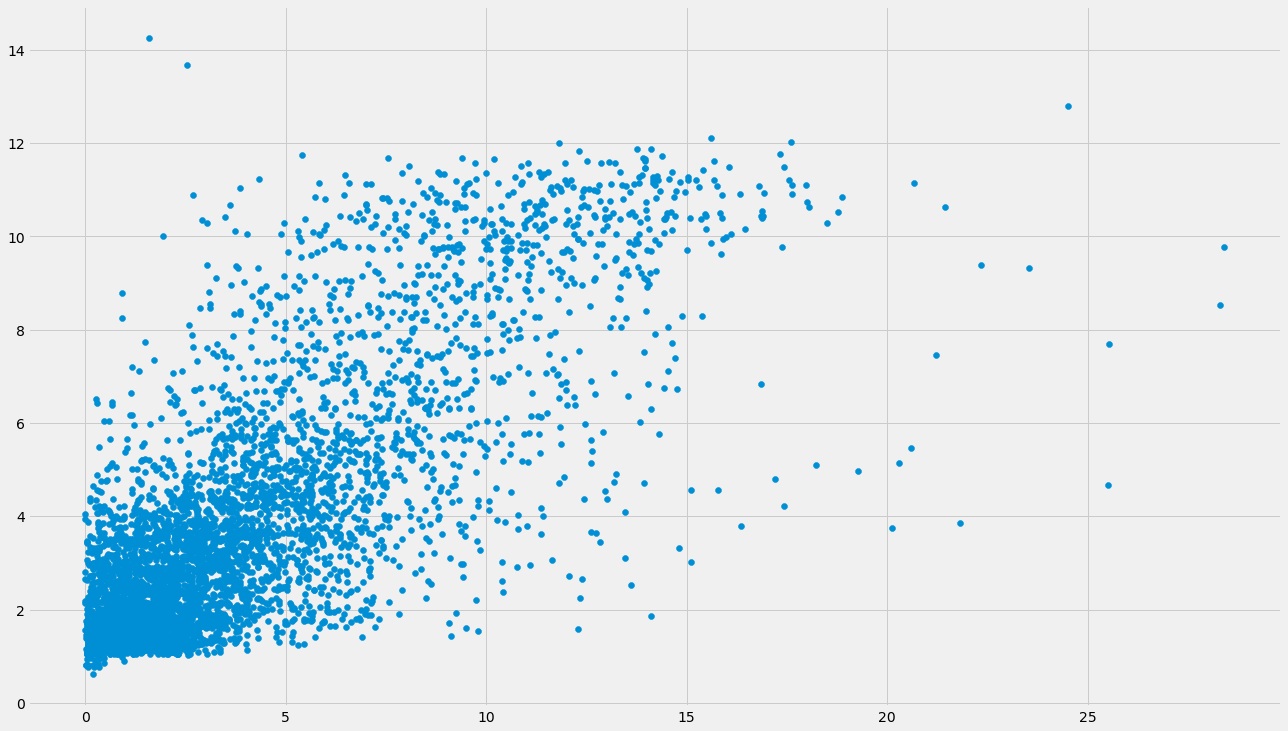

In [203]:
df_pred = pd.DataFrame(list(y_valid), columns = ['y_valid'])
df_pred['y_pred'] = list(y_pred)

plt.scatter(df_pred['y_valid'], df_pred['y_pred'])

# Evaluate final optimized model used on validation dataset

In [204]:
RF.MSE(df_pred['y_valid'], df_pred['y_pred'])

2.355243593452326

In [205]:
RF.MAE(df_pred['y_valid'], df_pred['y_pred'])

1.516029304620622

In [206]:
df_pred.corr()

,y_valid,y_pred
y_valid,1.00000,0.78369
y_pred,0.78369,1.00000


In [209]:
x = []
y = []
for i in range(0,100):
    i = i / 10
    x.append(i)
    y.append( sum( (df_pred['y_pred'] > df_pred['y_valid'] - i)  & (df_pred['y_pred'] < df_pred['y_valid'] + i) ) / len(df_pred) )

Text(0.5, 1.0, 'Regression Tree')

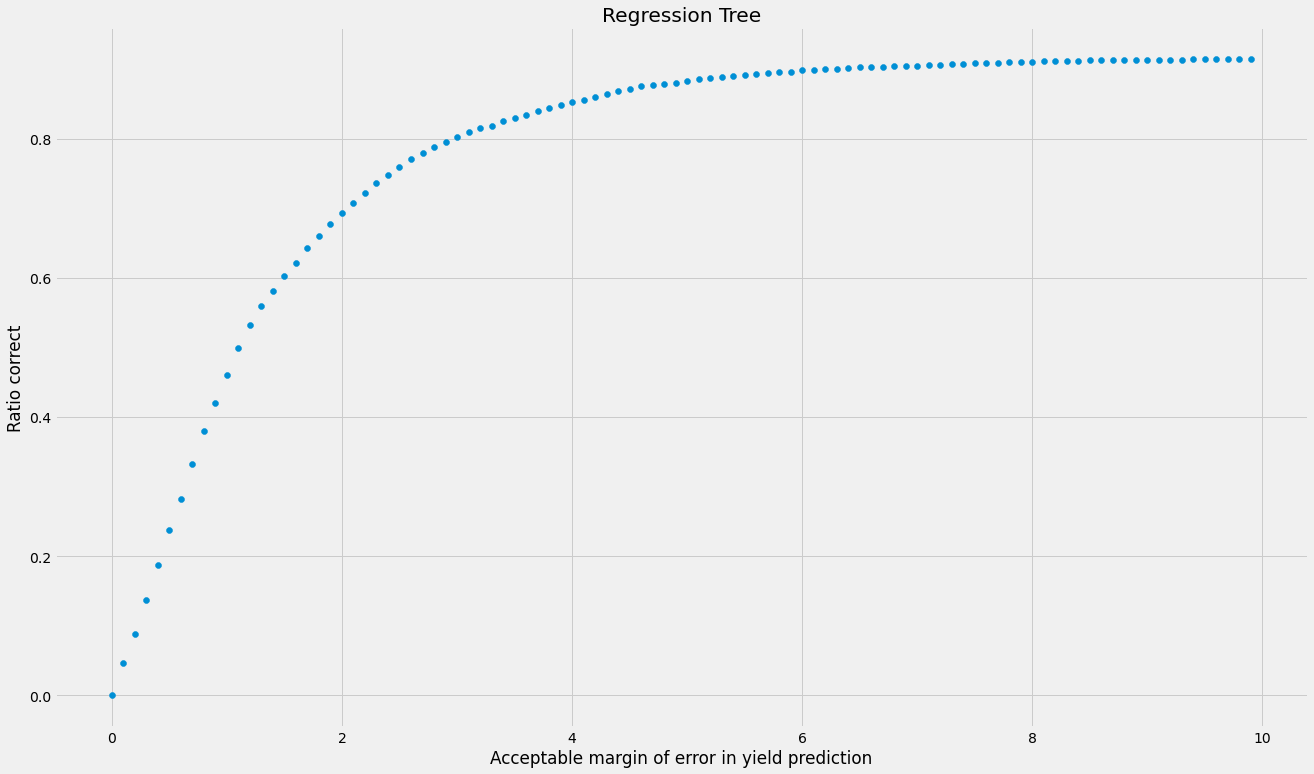

In [299]:
plt.scatter(x,y)
plt.xlabel('Acceptable margin of error in yield prediction')
plt.ylabel('Ratio correct')
plt.title('Regression Tree')

## Investigate Optimization space

Text(0.5, 1.0, ' Error vs Max Tree Depth')

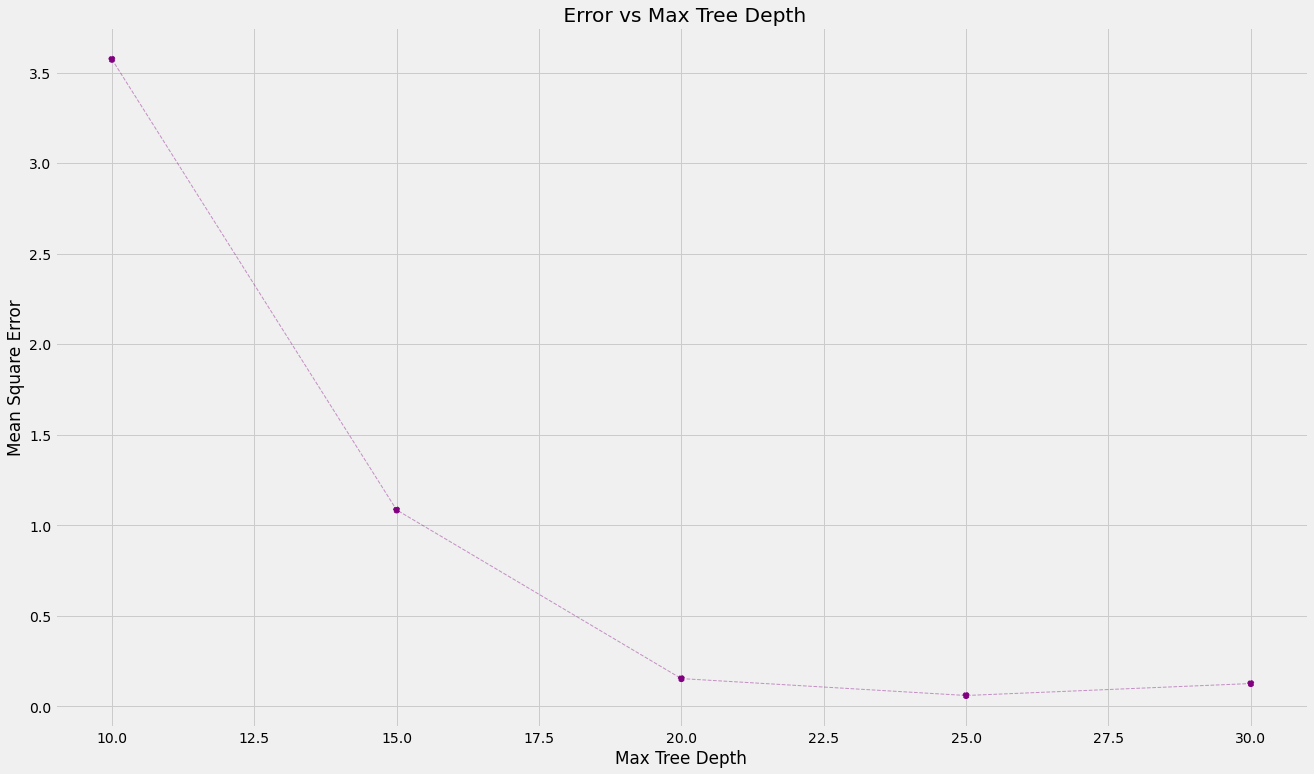

In [298]:
s = []
mse = []
for r in results:
    if r['params'][0] == 29.0:
        s.append(r['params'][1])
        mse.append(r['MSE'])

plt.plot(s, mse / np.mean(mse), c = 'purple', linewidth = 1, linestyle = '--', alpha = 0.4)
plt.scatter(s, mse / np.mean(mse), c = 'purple', linewidth = 1, linestyle = '--')
plt.xlabel('Max Tree Depth')
plt.ylabel('Mean Square Error')
plt.title(' Error vs Max Tree Depth')

Text(0.5, 1.0, ' Run time vs Max Tree Depth')

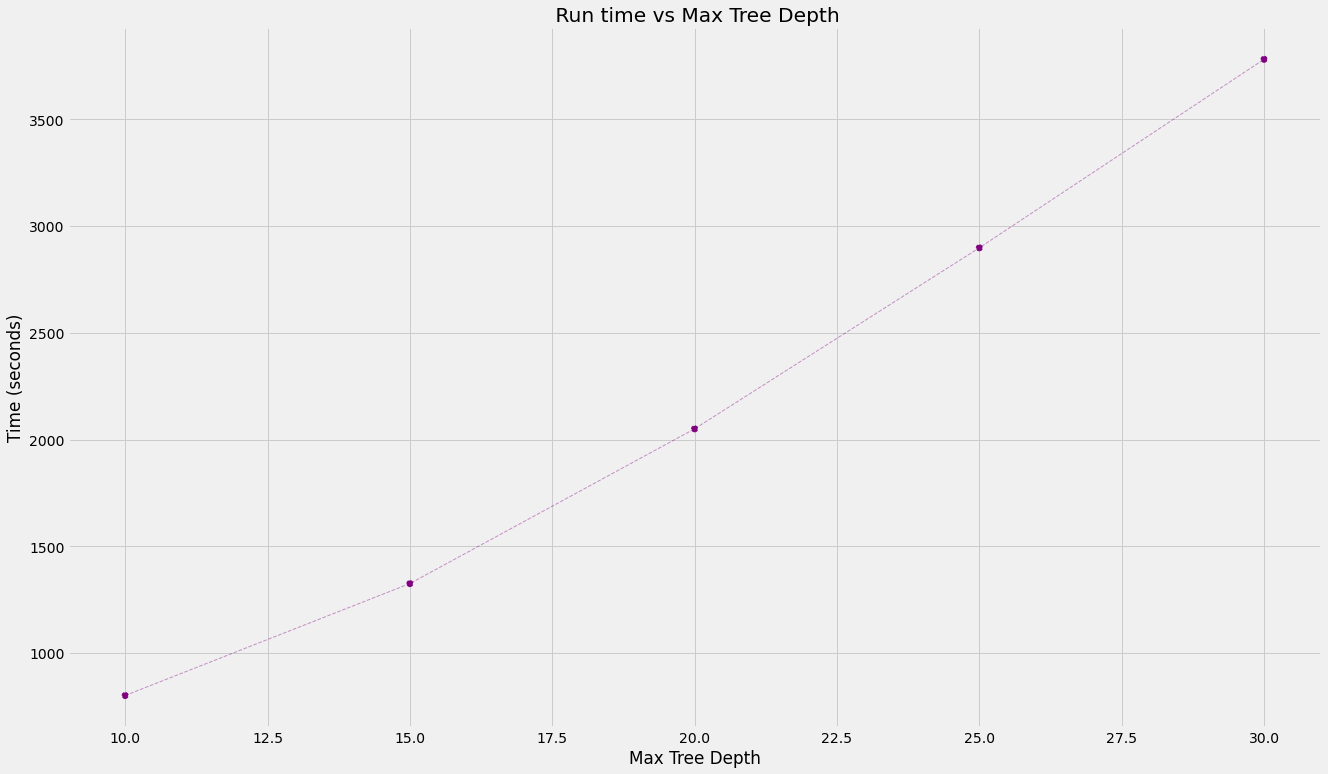

In [297]:
s = []
mse = []
for r in results:
    if r['params'][0] == 15.0:
        s.append(r['params'][1])
        mse.append(r['runtime'])

plt.plot(s, mse, c = 'purple', linewidth = 1, linestyle = '--', alpha = 0.4)
plt.scatter(s, mse, c = 'purple', linewidth = 1, linestyle = '--')
plt.xlabel('Max Tree Depth')
plt.ylabel('Time (seconds)')
plt.title(' Run time vs Max Tree Depth')

Text(0.5, 1.0, ' Error vs Number of Estimators')

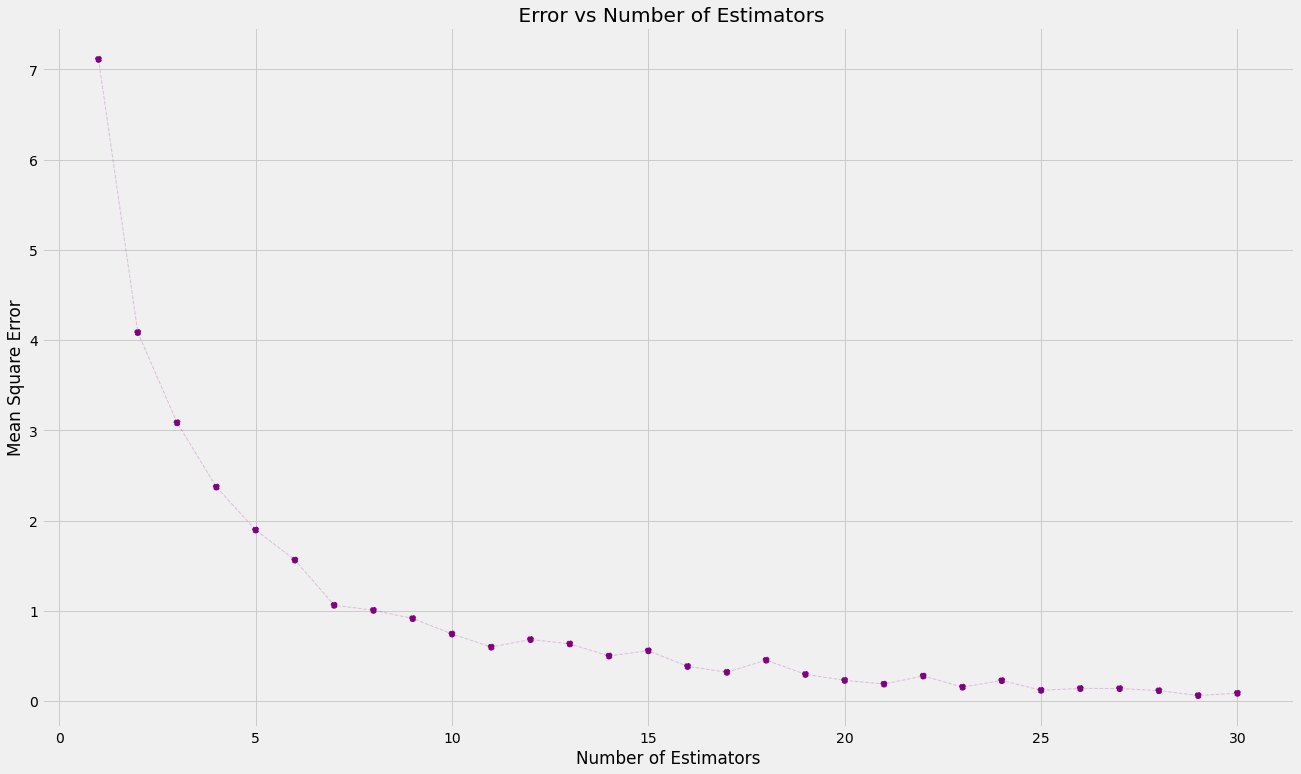

In [295]:
s = []
mse = []
for r in results:
    if r['params'][1] == 25.0:
        s.append(r['params'][0])
        mse.append(r['MSE'])

plt.plot(s, mse / np.mean(mse), c = 'purple', linewidth = 1, linestyle = '--', alpha = 0.2)
plt.scatter(s, mse / np.mean(mse), c = 'purple', linewidth = 1, linestyle = '--')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Square Error')
plt.title(' Error vs Number of Estimators')

Text(0.5, 1.0, ' Run time vs Number of Estimators')

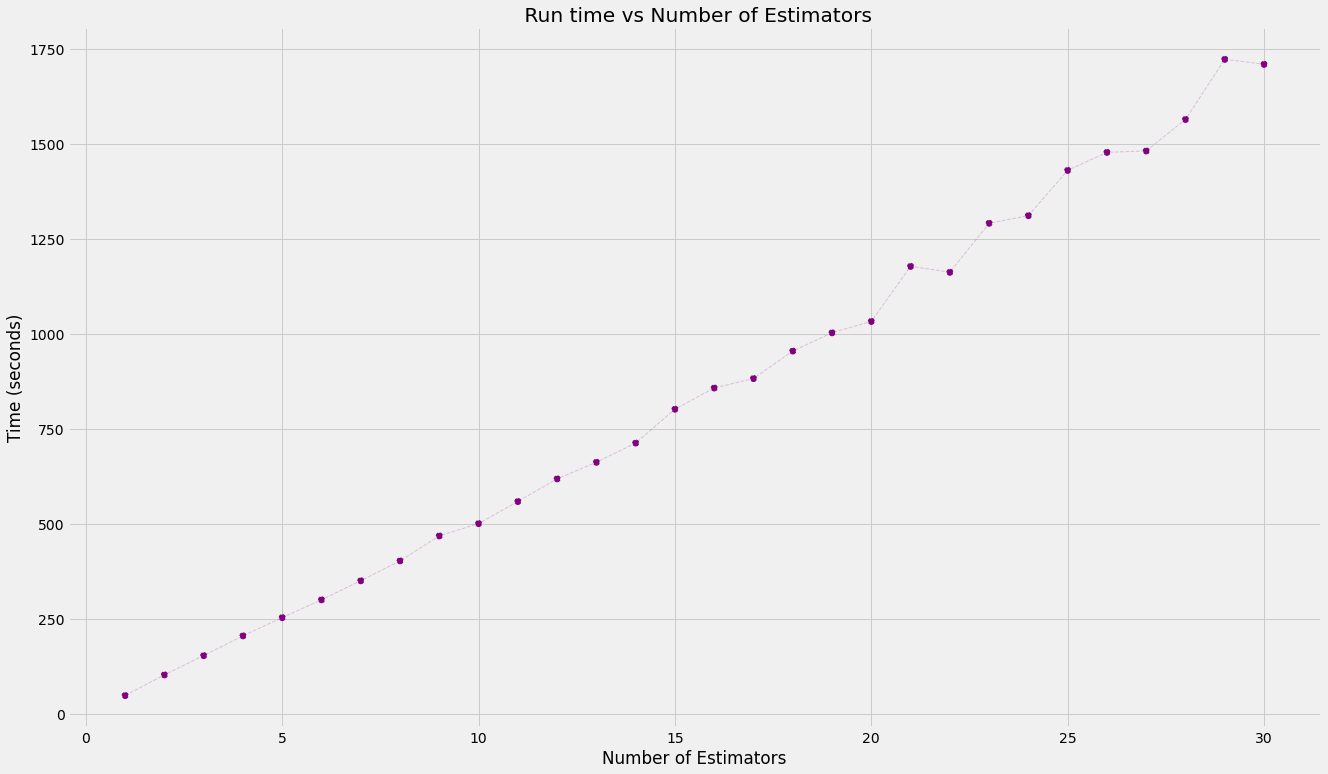

In [294]:
s = []
mse = []
for r in results:
    if r['params'][1] == 10.0:
        s.append(r['params'][0])
        mse.append(r['runtime'])

plt.plot(s, mse , c = 'purple', linewidth = 1, linestyle = '--', alpha = 0.2)
plt.scatter(s, mse , c = 'purple', linewidth = 1, linestyle = '--')
plt.xlabel('Number of Estimators')
plt.ylabel('Time (seconds)')
plt.title(' Run time vs Number of Estimators')

# Run model on training data to detect overfitting

In [254]:
RF = Random_Forest(x_train, y_train, x_train, y_train,
                  n_estimators = best_est,
                  min_leaf = 1, 
                  max_depth = best_depth)

RF.fit(x_train, y_train) # fit random forest model to training data

# use model to make predictions from validation data
y_pred_ontrain, MSE = RF.predict(x_train)

C:\Users\jdetu\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jdetu\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [255]:
y_pred_ontrain = unnormalize(y_pred_ontrain, train[1][-1],  train[2][-1])
y_train = unnormalize(y_train, train[1][-1],  train[2][-1])

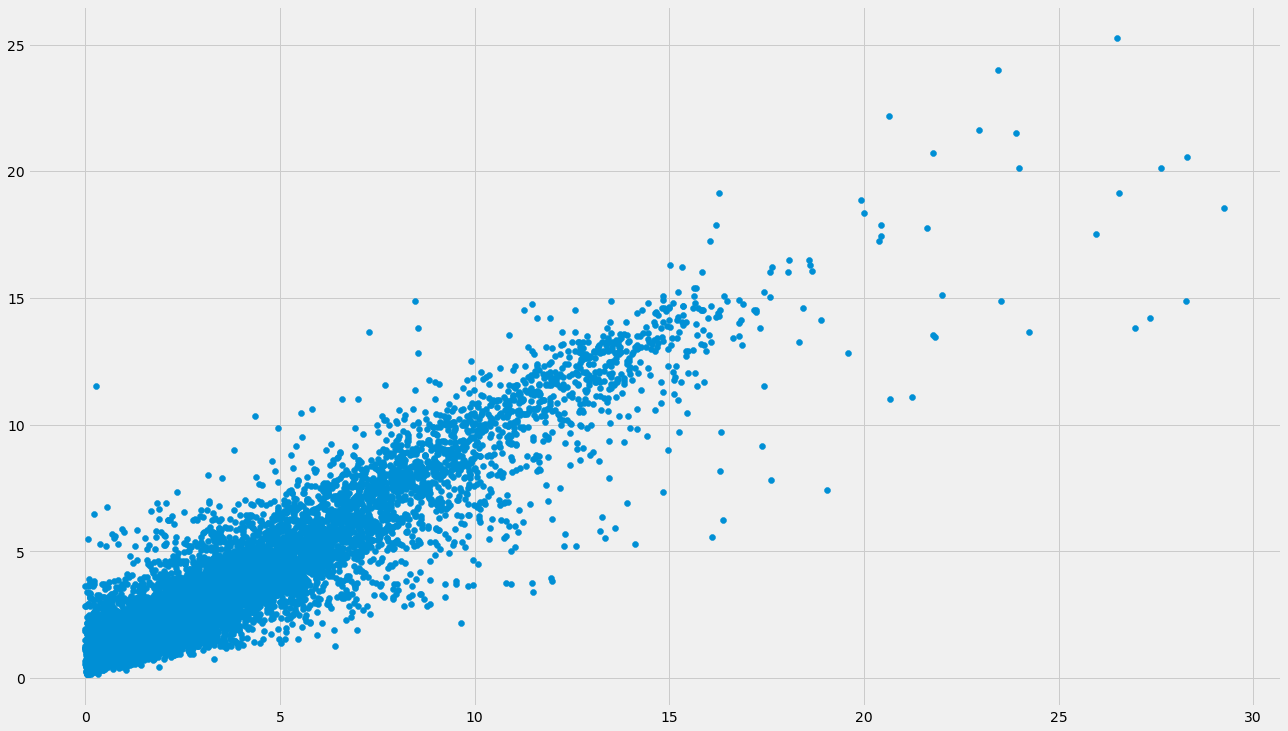

In [256]:
df_pred = pd.DataFrame(list(y_train), columns = ['y_train'])
df_pred['y_pred'] = list(y_pred_ontrain)

plt.scatter(df_pred['y_train'], df_pred['y_pred'])

In [257]:
df_pred.corr()
# significantly overfit to training data

,y_train,y_pred
y_train,1.000000,0.935242
y_pred,0.935242,1.000000
